In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.linear_model
%matplotlib inline

In [2]:
data = pd.read_csv('Cars93.csv')

In [31]:
X = data[['Horsepower', 'Turn.circle', 'MPG.highway']]
Y = data['Price'].values.reshape(-1,1)

x_obs = np.array(data[['Horsepower', 'Turn.circle', 'MPG.highway']])
y_obs = np.array(data['Price'].values.reshape(-1,1))
y_sigma_obs = np.std(y_obs)
np.shape(y_obs)

(93, 1)

7.1 Estimando con Bootstrapping (como en Piratas del Caribe)

In [13]:
n_boot = 5000
beta_0 = np.ones(n_boot)
beta_1 = np.ones(n_boot)
beta_2 = np.ones(n_boot)
beta_3 = np.ones(n_boot)
r2_train = np.ones(n_boot)
r2_validation = np.ones(n_boot)

linear = sklearn.linear_model.LinearRegression()
for i in range(n_boot):
    X_train, X_validation, Y_train, Y_validation = sklearn.model_selection.train_test_split(X, Y, test_size=0.5)
    linear.fit(X_train, Y_train)
    beta_0[i] = linear.intercept_[0]
    beta_1[i] = linear.coef_[0][0]
    beta_2[i] = linear.coef_[0][1]
    beta_3[i] = linear.coef_[0][1]
    r2_train[i] = linear.score(X_train, Y_train)
    r2_validation[i] = linear.score(X_validation, Y_validation) 

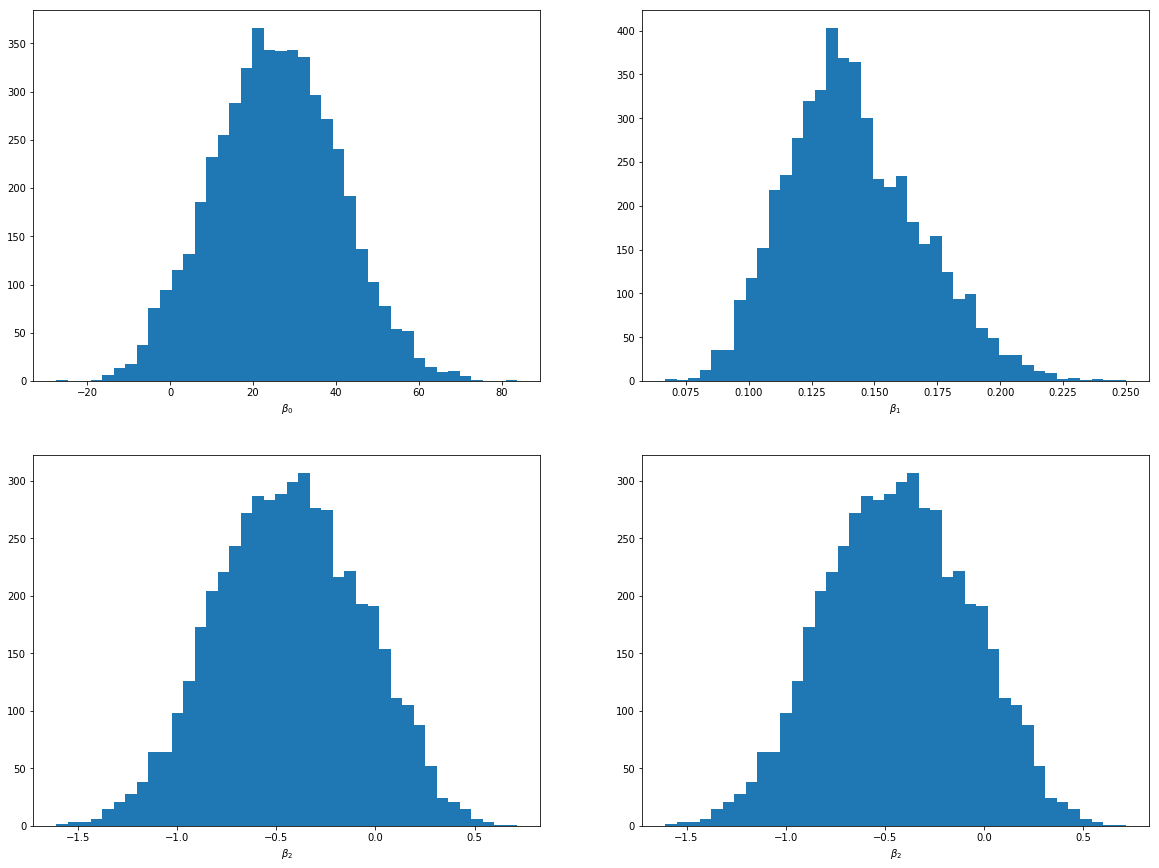

In [16]:
plt.figure(figsize=(20,15))

plt.subplot(221)
_ = plt.hist(beta_0, bins=40)
_ = plt.xlabel(r'$\beta_0$')

plt.subplot(222)
_ = plt.hist(beta_1, bins=40)
_ = plt.xlabel(r'$\beta_1$')

plt.subplot(223)
_ = plt.hist(beta_2, bins=40)
_ = plt.xlabel(r'$\beta_2$')

plt.subplot(224)
_ = plt.hist(beta_3, bins=40)
_ = plt.xlabel(r'$\beta_2$')


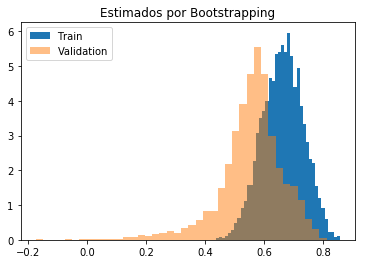

In [15]:
_ = plt.hist(r2_train, bins=40, density=True, label='Train')
_ = plt.hist(r2_validation, bins=40, alpha=0.5, density=True, label='Validation')

plt.title("Estimados por Bootstrapping")
plt.legend()

7.2  Ahora realicemos la estimacion de parametros con MCMC

In [69]:
def model(x, c):
    n_dim = len(c)
    y = np.zeros(len(x))
    y = c[0]
    for i in range(n_dim-1):
        y += c[i+1] * x[:,i]
    return y
        
def loglikelihood(x_obs, y_obs, y_sigma_obs, params):
    y_model = model(x_obs, params)
    d = -0.5 * ((y_model - y_obs)/y_sigma_obs)**2
    norm = np.sqrt(2.0 * np.pi * y_sigma_obs **2)
    return np.sum(d - np.log(norm))

def logprior(param):
    if (param[0]) < 100 and  (param[0])>(-30) and (param[0]) < 100 and  (param[1])>(-0.5) and (param[1]) < 0.5 and  (param[2])>(-2) and (param[3]) < 2 and  (param[3])>(-2):
        p = 0
    else:
        p = -np.inf
    return p

In [88]:
def metropolis(x_obs, y_obs,y_sigma_obs,p, N = 100000):
    l_param = [[20,0,0,0]]
    sigma_param = [1,0.0001,0.001,0.001]
    n_param = p
    logposterior = [0]
    for i in range(1,N):
        propuesta  = l_param[i-1] + np.random.normal(size=n_param)*sigma_param
        #print(propuesta)
        logposterior_viejo = loglikelihood(x_obs, y_obs,y_sigma_obs, l_param[i-1]) + logprior(l_param[i-1])
        logposterior_nuevo = loglikelihood(x_obs, y_obs,y_sigma_obs, propuesta) + logprior(propuesta)

        r = min(1,np.exp(logposterior_nuevo-logposterior_viejo))
        alpha = np.random.random()
        if(alpha<r):
            l_param.append(propuesta)
            logposterior.append(logposterior_nuevo)
        else:
            l_param.append(l_param[i-1])
            logposterior.append(logposterior_viejo)
    
    l_param = np.array(l_param)
    logposterior = np.array(logposterior)
    return l_param, logposterior

In [89]:
param, posterior = metropolis(x_obs, y_obs,y_sigma_obs,4)
print(param[-1])

[1.67968769e+01 1.54560865e-03 4.15387924e-02 2.91369563e-02]


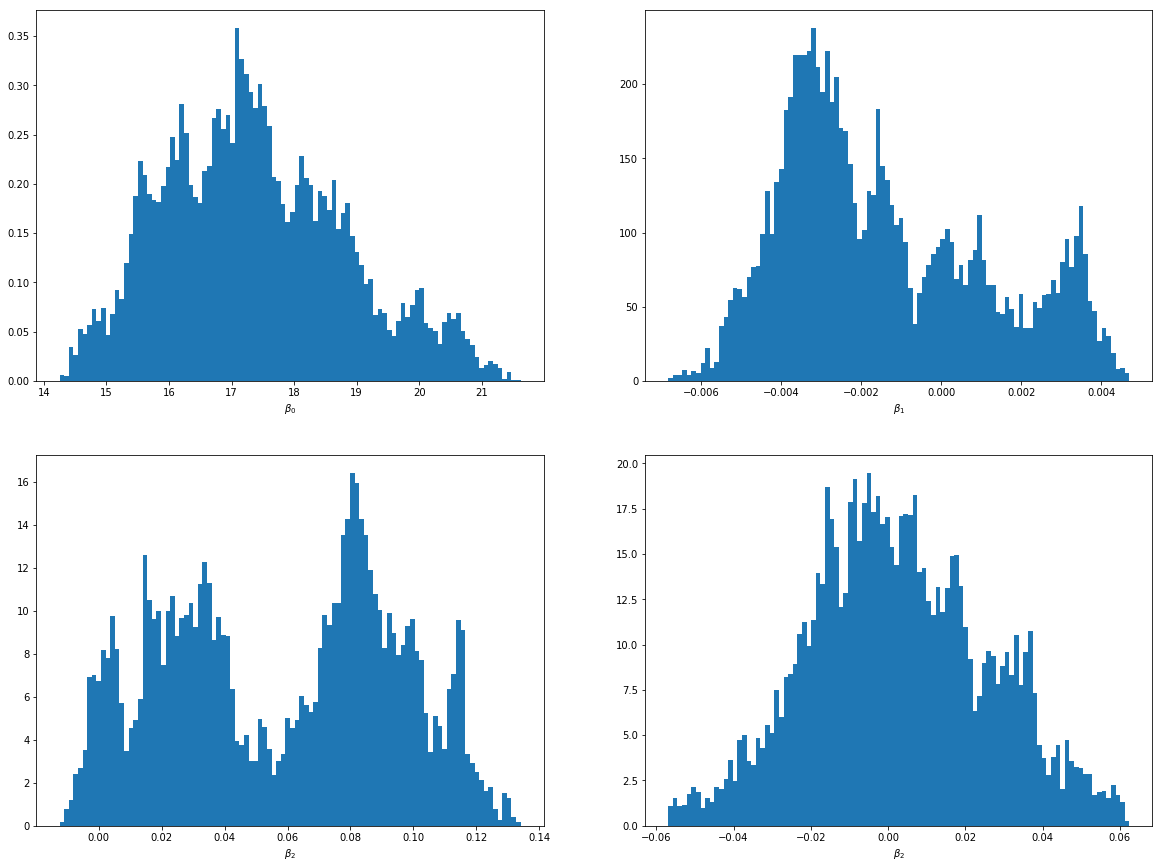

In [91]:
plt.figure(figsize=(20,15))

plt.subplot(221)
_= plt.hist(param[:,0],bins=100, density=True)
_ = plt.xlabel(r'$\beta_0$')

plt.subplot(222)
_= plt.hist(param[:,1],bins=100, density=True)
_ = plt.xlabel(r'$\beta_1$')

plt.subplot(223)
_= plt.hist(param[:,2],bins=100, density=True)
_ = plt.xlabel(r'$\beta_2$')

plt.subplot(224)
_= plt.hist(param[:,3],bins=100, density=True)
_ = plt.xlabel(r'$\beta_2$')



In [ ]:
print(param[])